In [10]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [11]:
import liana as li

In [12]:
from matplotlib.pyplot import hist

In [13]:
counts = pd.read_csv("data/counts_mat.csv")
weights = pd.read_csv("data/weight_mat.csv")

In [14]:
var = pd.DataFrame(counts[['Unnamed: 0']]).set_index('Unnamed: 0')
var.index.name = None

In [15]:
adata = sc.AnnData(X=csr_matrix(counts.drop(counts.columns[0], axis=1), dtype=np.float32).T, var=var)

In [16]:
adata.obsm['proximity'] = csr_matrix(weights)

In [17]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [18]:
adata

AnnData object with n_obs × n_vars = 260 × 43
    obsm: 'proximity'

In [65]:
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2"], "receptor":["Gucy1b3", "Mtor", "Tuba1a"]})

In [66]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

Using `.X`!
Converting mat to CSR format


In [67]:
lr_res

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
0,Dnm1l&Gucy1b3,Dnm1l,Gucy1b3,Dnm1l,Gucy1b3,2.682889,0.950000,3.117442,0.976923,0.950000
1,Arrb1&Mtor,Arrb1,Mtor,Arrb1,Mtor,2.665413,0.957692,2.298451,0.907692,0.907692
2,Igf2&Tuba1a,Igf2,Tuba1a,Igf2,Tuba1a,1.924077,0.892308,6.466562,1.000000,0.892308


Correlations

In [68]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [69]:
x, y = ligand_mat[0, :].A.flatten(), receptor_mat[0, :].A.flatten()

In [70]:
from scipy.stats import spearmanr, pearsonr, pointbiserialr, kendalltau

In [71]:
pearsonr(x, y)

(0.12061560721706954, 0.05206512033238492)

One by One

In [72]:
def wcor(x, y, weight):
    weight_sum = np.sum(weight)
    
    numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
    denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
    denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2
    
    wcor = numerator / np.sqrt(denominator_x * denominator_y)
    
    return wcor

In [73]:
adata.obsm['proximity']

<260x260 sparse matrix of type '<class 'numpy.float64'>'
	with 3120 stored elements in Compressed Sparse Row format>

In [74]:
i = 0

In [75]:
# all weights = 1 (i.e. pearsonr)
wcor(x, y, np.repeat(1, x.shape[0]))

0.12061560565466811

In [76]:
weight = adata.obsm['proximity']

In [77]:
# calculate all local correlations
# technically, if we take i (a spot), x and y (e.g. genes),
# we go over all rows in w (i.e. every spot)
# and we re-calculate PC with the spatial weights 
# for the spots i to any other spot (j)
local_corrs = []
for i in range(weight.shape[0]):
    local_corrs.append(wcor(x, y, weight[i, :].A))
local_corrs = np.array(local_corrs)

(array([ 9., 25., 27., 37., 26., 43., 37., 35., 14.,  7.]),
 array([-0.58677481, -0.45093227, -0.31508972, -0.17924717, -0.04340463,
         0.09243792,  0.22828047,  0.36412302,  0.49996556,  0.63580811,
         0.77165066]),
 <BarContainer object of 10 artists>)

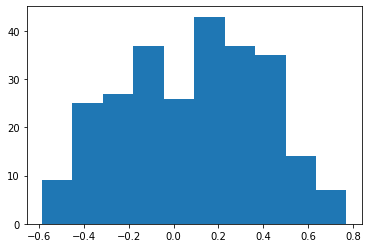

In [78]:
hist(local_corrs)

In [79]:
local_corrs

array([-1.32964636e-03,  1.78378033e-01, -6.99203744e-04,  7.18299187e-04,
       -2.14034393e-01, -2.15510184e-02, -2.38989051e-03, -7.09542255e-02,
       -7.78087740e-02,  2.09318414e-01,  2.81858651e-02, -5.68777218e-02,
        1.82043598e-01,  3.44058245e-01,  3.75013963e-01,  4.18542795e-02,
        1.68156230e-01,  6.15738202e-01,  3.02646253e-01,  2.82138089e-01,
        1.59544917e-01, -8.49139453e-02,  3.12473112e-01,  4.09399035e-01,
        4.52031150e-01,  4.61461128e-01,  3.49804439e-01,  1.68055224e-01,
       -3.54433375e-01,  1.44093762e-01,  1.01623378e-01,  3.10269403e-01,
        1.07867065e-01, -8.87894317e-02, -1.03981598e-01,  1.35644097e-01,
        1.05247473e-01,  1.91265777e-01,  1.85502205e-01, -2.60868345e-01,
       -1.78722430e-01,  4.82366112e-01, -3.72962447e-01,  5.03809260e-01,
       -2.66589328e-01,  2.77417567e-01,  6.98883674e-01,  4.20123467e-01,
        6.91857338e-01,  7.71650657e-01, -3.79685627e-01, -3.32504202e-02,
        6.59314392e-01,  

Vectorize